## Histopathologic Cancer Detection

### Problem Description

This competition is a binary image classification task focused on detecting metastatic cancer in histopathology images. The goal is to develop an algorithm that predicts the probability that a small tissue patch contains metastatic tumor cells. Submissions are evaluated using the *Area Under the ROC Curve (AUC)*, which measures how well the model separates cancerous from non-cancerous patches.

### Data Description

The dataset is a modified version of the PatchCamelyon (PCam) benchmark: 

- Images: Small color patches (RGB) cropped from high-resolution digital pathology scans. Each patch shows a region of lymph node tissue.

- Labels:

    1 – The patch contains metastatic cancer.

    0 – No cancer is present in the patch.

The Kaggle version removes duplicate patches present in the original PCam dataset to ensure clean training and evaluation.

Files: A CSV file provides image IDs and corresponding binary labels for the training set. A separate test set contains images without labels for prediction.

The goal is to accurately identify microscopic cancerous regions despite variability in tissue appearance, staining, and imaging conditions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import os
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from fastai.callback.all import SaveModelCallback, CSVLogger

import os
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score
from torchvision.models import resnet50, densenet201, efficientnet_b3
from fastai.tabular.all import *
import torch
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-23 16:30:52.175598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758645052.380892      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758645052.442989      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [4]:
train_df.duplicated().sum()

0

## Exploratory Data Analysis 

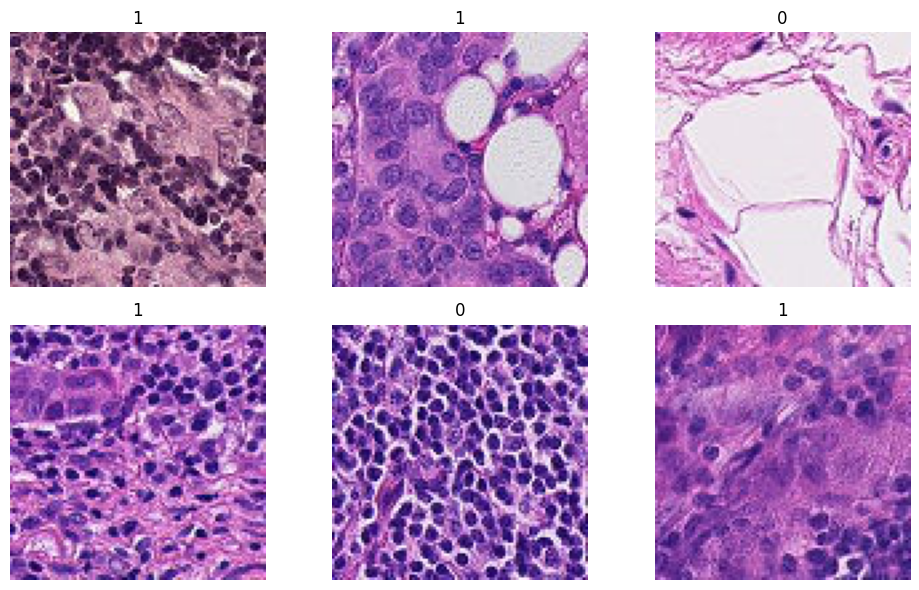

In [5]:
train_df['img_path'] = train_df['id'].apply(lambda x: os.path.join(
    '/kaggle/input/histopathologic-cancer-detection/train',f"{x}.tif"
))
def view_sample_images(df, no_sample =None,label_col =None, img_col='id'):
    sample_df = df.sample(no_sample)  
    plt.figure(figsize=(10, 6))
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = mpimg.imread(row[img_col])
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        if label_col:
            plt.title(str(row[label_col]))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
view_sample_images(train_df, no_sample =6,label_col ='label',img_col='img_path')

In [6]:
#Get image shape 
img = mpimg.imread(train_df['img_path'][0])
img.shape

(96, 96, 3)

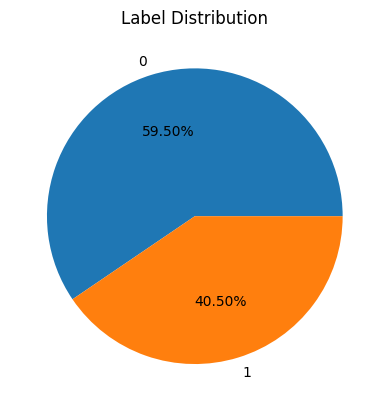

In [7]:
# Check class distribution 
labels = train_df['label'].value_counts(normalize=True)
plt.pie(labels,autopct='%1.2f%%',labels=labels.index)
plt.title('Label Distribution');

To gain an initial understanding of the dataset, the following steps were performed:

1. Sample Visualization:

    Randomly selected and displayed a set of training images to inspect tissue appearance, staining patterns, and general quality of the data.

2. Image Properties:

    Checked the image dimensions and color channels to confirm consistency across files (e.g., verifying all patches have the same width, height, and RGB format).

3. Label Distribution:

    Plotted the frequency of the binary labels (0 = normal, 1 = metastatic cancer) to evaluate class balance.

This step helps determine whether techniques such as class weighting or oversampling may be needed during model training.

These checks confirmed the data is clean and consistently formatted, while also revealing the level of class imbalance that should be considered when selecting a loss function and evaluation strategy.

## Model Building and Training

Two complementary modeling strategies were explored:
1. **Stacked Model (Ensemble of CNN Backbones)**

The first approach trains multiple deep convolutional networks separately and then combines their predictions using a meta-learner:
* Base Models: ResNet50, DenseNet201, and EfficientNetB3 were trained using the fastai framework.
* Training Setup: Images were resized to match each model’s input size and augmented with random flips, rotations, and color normalization.
* Each model was fine-tuned for several epochs using transfer learning with the ROC-AUC metric for early stopping.

**Prediction Storage:** After training, validation and test predictions from each backbone were saved as CSV files.

**Stacking:** The out-of-fold validation predictions were combined into a new tabular dataset.

A small feed-forward network served as a meta-learner, trained to predict the ground-truth label from the base model outputs.

2. **Transfer Learning with EfficientNetB0**

The second approach leverages a single strong backbone with custom fine-tuning:
* Architecture: An EfficientNetB0 pretrained on ImageNet was used as the feature extractor, with a custom head consisting of global average pooling, batch normalization, dropout, and a sigmoid output layer for binary classification.
* Data Pipeline: Images were scaled to 96 × 96 pixels and rescaled to [0,1].
* Data augmentation included random rotations, flips, shifts, zoom, and brightness changes.
* Training: The model was compiled with the Adam optimizer and binary cross-entropy loss, using AUC as the primary metric.
* Class weights were computed to counteract label imbalance.
* Early stopping, learning-rate reduction on plateau, and model checkpointing ensured stable training and retention of the best weights.

### Train Base Models (ResNet50, DenseNet201, EfficientNetB3)

In [8]:
def build_model(model_arch, batch_size=64, image_size=96, 
                validation_pct=0.2, 
                test_path='/kaggle/input/histopathologic-cancer-detection/test', 
                model_name='model'):
    """
    Train a CNN on train_df and save validation + test predictions for stacking.
    Will save best weights and reload automatically if already trained.
    """
    # DataBlock & DataLoaders
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader('img_path'),
        get_y=ColReader('label'),
        splitter=RandomSplitter(valid_pct=validation_pct, seed=42),
        item_tfms=Resize(image_size),
        batch_tfms=[*aug_transforms(size=image_size), Normalize.from_stats(*imagenet_stats)]
    )
    dls = dblock.dataloaders(train_df, bs=batch_size)

    # Learner
    learn = vision_learner(dls, model_arch, metrics=[accuracy, RocAucBinary()])
    learn.to_fp16()

    # Path to save model
    model_path = f'{model_name}_checkpoint'

    # Try to load best model if exists
    if (learn.path/f'models/{model_path}.pth').exists():
        learn.load(model_path)
        print(f"Loaded checkpoint: {model_path}")
    else:
        print("No checkpoint found, starting fresh training.")
        cbs = [
            SaveModelCallback(monitor='roc_auc_score', fname=model_path),  # save best model
            CSVLogger(fname=f'{model_name}_history.csv')  # training log
        ]
        learn.fine_tune(5, cbs=cbs)

    # Save validation predictions
    val_preds, val_targs = learn.get_preds(ds_idx=1)
    pd.DataFrame({
        'val_0': val_preds[:,0].numpy(),
        'val_1': val_preds[:,1].numpy(),
        'ground_truth_label': val_targs.numpy()
    }).to_csv(f'{model_name}_val_preds.csv', index=False)

    # Save test predictions
    test_files = get_image_files(test_path)
    test_dl = dls.test_dl(test_files)
    test_preds, _ = learn.get_preds(dl=test_dl)
    pd.DataFrame({
        'id': [f.stem for f in test_files],
        'pred_0': test_preds[:,0].numpy(),
        'pred_1': test_preds[:,1].numpy()
    }).to_csv(f'{model_name}_test_preds.csv', index=False)

    print(f"{model_name} training & predictions saved")


In [9]:
# Train ResNet50
build_model(resnet50, model_name='resnet50')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.405103,0.360548,0.844472,0.914344,09:23


Better model found at epoch 0 with roc_auc_score value: 0.9143440678471755.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.220360,0.211517,0.922850,0.971421,06:07
1,0.163863,0.161283,0.941848,0.983166,05:57
2,0.131070,0.151317,0.946211,0.984973,06:00
3,0.112675,0.113428,0.959800,0.990964,05:55
4,0.096117,0.109988,0.960823,0.991438,06:06


Better model found at epoch 0 with roc_auc_score value: 0.9714211471623293.
Better model found at epoch 1 with roc_auc_score value: 0.9831664817925485.
Better model found at epoch 2 with roc_auc_score value: 0.9849729770951979.
Better model found at epoch 3 with roc_auc_score value: 0.9909637245859652.
Better model found at epoch 4 with roc_auc_score value: 0.9914384016367114.


resnet50 training & predictions saved


In [10]:
# Train DenseNet201
build_model(densenet201, model_name='densenet201')

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 115MB/s] 


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.233864,0.191714,0.926372,0.975498,09:34


Better model found at epoch 0 with roc_auc_score value: 0.9754978557081982.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.186212,0.149025,0.944688,0.984793,11:42
1,0.144450,0.124912,0.955028,0.989681,11:46
2,0.107683,0.111736,0.960300,0.992149,11:46
3,0.084521,0.094785,0.967708,0.993694,12:01
4,0.068436,0.093583,0.968504,0.994035,11:47


Better model found at epoch 0 with roc_auc_score value: 0.9847929668999865.
Better model found at epoch 1 with roc_auc_score value: 0.9896812641585204.
Better model found at epoch 2 with roc_auc_score value: 0.9921494921558212.
Better model found at epoch 3 with roc_auc_score value: 0.9936935887365007.
Better model found at epoch 4 with roc_auc_score value: 0.9940346038976885.


densenet201 training & predictions saved


In [11]:
# Train EfficientNetB3
build_model(efficientnet_b3, model_name='efficientnetb3', image_size=224)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 220MB/s]


No checkpoint found, starting fresh training.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.378665,0.333241,0.856744,0.930546,13:42


Better model found at epoch 0 with roc_auc_score value: 0.930546494465733.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.292988,0.243441,0.903102,0.961698,20:16
1,0.236742,0.191243,0.928258,0.976474,20:14
2,0.203071,0.159868,0.940370,0.982923,20:13
3,0.188475,0.148053,0.945438,0.985330,20:12
4,0.189678,0.147649,0.944824,0.985259,20:13


Better model found at epoch 0 with roc_auc_score value: 0.9616978841928756.
Better model found at epoch 1 with roc_auc_score value: 0.9764736058422366.
Better model found at epoch 2 with roc_auc_score value: 0.9829233146036156.
Better model found at epoch 3 with roc_auc_score value: 0.9853300340855999.


efficientnetb3 training & predictions saved


In [12]:
# Load validation preds
res50_val = pd.read_csv('resnet50_val_preds.csv')
dense201_val = pd.read_csv('densenet201_val_preds.csv')
effb3_val = pd.read_csv('efficientnetb3_val_preds.csv')

# Load test preds
res50_test = pd.read_csv('resnet50_test_preds.csv')
dense201_test = pd.read_csv('densenet201_test_preds.csv')
effb3_test = pd.read_csv('efficientnetb3_test_preds.csv')

# Train stacking dataframe
train_stack = pd.DataFrame({
    'res50_0': res50_val.val_0, 'res50_1': res50_val.val_1,
    'dense201_0': dense201_val.val_0, 'dense201_1': dense201_val.val_1,
    'effb3_0': effb3_val.val_0, 'effb3_1': effb3_val.val_1,
    'y': res50_val.ground_truth_label
})

# Test stacking dataframe
test_stack = pd.DataFrame({
    'res50_0': res50_test.pred_0, 'res50_1': res50_test.pred_1,
    'dense201_0': dense201_test.pred_0, 'dense201_1': dense201_test.pred_1,
    'effb3_0': effb3_test.pred_0, 'effb3_1': effb3_test.pred_1
})


### Train Meta-Learner 

In [13]:
cont_names = list(train_stack.columns[:-1])  # model outputs
dep_var = 'y'

# Make y categorical
train_stack[dep_var] = train_stack[dep_var].astype(str)

# DataLoaders
splits = RandomSplitter(seed=42)(range_of(train_stack))
to = TabularPandas(train_stack, procs=[],
                   cont_names=cont_names,
                   y_names=dep_var,
                   y_block=CategoryBlock(),  
                   splits=splits)
dls = to.dataloaders(bs=64)

# Custom ROC AUC metric
def roc_score(inp, targ):
    # Convert to probabilities
    probs = inp.softmax(dim=1)[:,1].cpu().numpy()
    return roc_auc_score(targ.cpu().numpy(), probs)

# Meta-learner
learn = tabular_learner(dls, layers=[20,10],
                        metrics=[accuracy, roc_score],
                        wd=1e-2)

# Train
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_score,time
0,0.182233,0.176017,0.955346,0.992355,00:03
1,0.095912,0.096513,0.970117,0.993578,00:03
2,0.095184,0.094301,0.969890,0.993244,00:03
3,0.091144,0.091922,0.970458,0.993487,00:03
4,0.088683,0.094648,0.968526,0.993409,00:03
5,0.085224,0.092349,0.970344,0.993656,00:03
6,0.082888,0.092693,0.969549,0.993410,00:03
7,0.091589,0.091850,0.968413,0.993624,00:03
8,0.090738,0.091874,0.970231,0.993604,00:03
9,0.098272,0.091850,0.968754,0.993769,00:03


In [14]:
# Predict on test set
test_dl = learn.dls.test_dl(test_stack)
preds, _ = learn.get_preds(dl=test_dl)

# Submission (probability for cancer class = column 1)
submission = pd.DataFrame({
    'id': res50_test.id,  # all test sets have same order
    'label': preds[:,1].numpy()
})

submission.to_csv('submission.csv', index=False)


## ImageDataGenerator

In [9]:
#Extract image width and height info
h,w = img.shape[:2]
IMG_SIZE= (h,w)
#Use ImageDataGenerator to rescale and split images 
train_gen = ImageDataGenerator(
    rescale =1./255,
    validation_split = 0.25
)

In [10]:
# Use flow_from_dataframe to link image path to labels, 
# split data into training and validation samples 
# and generate training batches during training 
train_generator = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(96,96),
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    directory=None ,
    subset='training',
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

valid_generator = train_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='label',
    target_size=(96,96),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42,
    directory=None,
    subset = 'validation'
)


Found 165019 validated image filenames.
Found 55006 validated image filenames.


In [11]:
base_model = EfficientNetB0(
    input_shape=(96, 96, 3), 
    weights='imagenet', 
    include_top=False
)
base_model.trainable = True 

# Build custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_auc',
                           patience=5, 
                           mode='max', 
                           restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_auc', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=1e-6, 
                              mode='max')

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_df['label']),
                                     y=train_df['label'])

class_weights = dict(enumerate(class_weights))

checkpoint = ModelCheckpoint(
    'efficientnet_best.h5',   # file to save model
    monitor='val_auc',        
    mode='max',
    save_best_only=True,
    save_weights_only=False   # saves full model (weights + optimizer state)
)

callbacks = [early_stop, lr_reduce, checkpoint]
# Train model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stop, lr_reduce],
    class_weight=class_weights
)

I0000 00:00:1757784709.386181      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1757784764.384939     124 service.cc:148] XLA service 0x7cc2101bdd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757784764.385583     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757784769.311136     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1757784775.894100     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757784776.076816     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757784776.555020     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757784776.7450

   1/5157 ━━━━━━━━━━━━━━━━━━━━ 121:21:21 85s/step - auc: 0.5391 - loss: 0.9291

I0000 00:00:1757784797.039463     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3904/5157 ━━━━━━━━━━━━━━━━━━━━ 3:08 151ms/step - auc: 0.8662 - loss: 0.4967

E0000 00:00:1757785394.436098     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757785394.620180     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757785395.187335     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757785395.380033     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757785395.668923     124 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1243s 225ms/step - auc: 0.8795 - loss: 0.4664 - val_auc: 0.8895 - val_loss: 0.4324 - learning_rate: 1.0000e-04
Epoch 2/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 411s 80ms/step - auc: 0.9701 - loss: 0.2194 - val_auc: 0.6921 - val_loss: 1.9064 - learning_rate: 1.0000e-04
Epoch 3/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 272s 53ms/step - auc: 0.9839 - loss: 0.1581 - val_auc: 0.8799 - val_loss: 0.7555 - learning_rate: 1.0000e-04
Epoch 4/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 270s 52ms/step - auc: 0.9921 - loss: 0.1097 - val_auc: 0.9845 - val_loss: 0.1497 - learning_rate: 2.0000e-05
Epoch 5/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 268s 52ms/step - auc: 0.9944 - loss: 0.0904 - val_auc: 0.9514 - val_loss: 0.3251 - learning_rate: 2.0000e-05
Epoch 6/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 268s 52ms/step - auc: 0.9954 - loss: 0.0819 - val_auc: 0.9778 - val_loss: 0.2459 - learning_rate: 2.0000e-05
Epoch 7/50
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 268s 52ms/step - auc: 0.9963 - loss: 0.0722 - val_auc: 0.9895

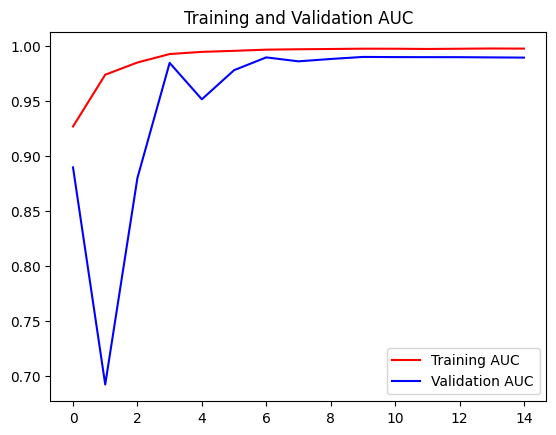

In [12]:
#Extract training auc 
auc = history.history['auc']
#get validation auc
val_auc = history.history['val_auc']

epochs_range = range(len(auc))

#plot training and validation auc curve 
plt.plot(epochs_range, auc, 'r', label="Training AUC")
plt.plot(epochs_range, val_auc, 'b', label="Validation AUC")
plt.title("Training and Validation AUC")
plt.legend()
plt.show()

## Results
Both the stacked meta-learner and the EfficientNetB0 model achieved strong validation performance, but their test set results revealed a clear performance gap:

|Model|Validation ROC AUC| Test ROC AUC|Validation Loss|
|:--|:--|:--|:--|
|Stacked Model (ResNet50, DenseNet201, and EfficientNetB3 with tabular meta-learner)|0.9938|0.962|0.0900|
|EfficientNetB0 (Transfer Learning)| 0.9893|0.8530|0.1233|


**Key Observations**
1. Training Time & Inference Speed

    * The stacked meta-learner required a longer training process, as it first trained multiple base models and then an additional meta-learner.

    * This extended pipeline also meant that applying the stacked model to the test set took longer compared to a single-model approach.

2. EfficientNetB0 Training Behavior

    * Rapid Initial Gains: EfficientNetB0 achieved a strong *AUC of 0.8795* after the first epoch, but validation AUC sharply declined in the second epoch (0.6921) while validation loss spiked, indicating instability or overfitting to early batches.

    * By around the 7th epoch, both validation AUC and loss began to stabilize, suggesting the model eventually found a more generalizable set of weights after the initial fluctuations.

3. Performance vs. Efficiency Trade-off

    * The stacked model achieved the highest test *ROC AUC 0.9620* but at the cost of greater computational demand.

    * EfficientNetB0 was faster to train and deploy, making it more practical for time-constrained scenarios, though it ultimately delivered a lower test *ROC AUC 0.8530*.
  
## Discussion & Conclusion
* The stacked meta-learner clearly outperformed the single EfficientNetB0 model on the held-out test set, confirming that ensembles can generalize better by leveraging complementary strengths of diverse CNN backbones
  
* Although EfficientNetB0 performed well on the validation set, the substantial test-set drop $\approx 0.14$ suggests that it may have captured dataset-specific patterns that did not transfer well to unseen data.

### Conclusion:

While both models achieved high validation metrics, the stacked meta-learner demonstrated superior real-world generalization, making it the preferred solution for deployment in histopathologic cancer detection. EfficientNetB0 remains a valuable lightweight baseline but would require further tuning or augmentation to approach the ensemble’s robustness.